## Plotting networks with python

In some instances a nice way to visualize relationship of many variables is to plot it as a network of notes. 

### Dataset
I will be using a temperature dataset from [kaggle](https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities). 

### Tools
[**networkx**](https://networkx.org/) is a handy python package for plotting anything network-related  
[**pingouin**](https://pingouin-stats.org/build/html/index.html) is a package with statistical tools

In [1]:
from groo.groo import get_root
import pandas as pd
import os
import seaborn as sns
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx


### Load and clean data

In [2]:
# Load data
rawdf = pd.read_csv(os.path.join(get_root(".weather"), "data", "city_temperature.csv"))

# Select a few countries and few years
countries = ["Togo", "Canada", "Uganda", "Slovakia", "Russia", "Australia", "Argentina"]

# data between 2000 and 2005, neither included
rawdf = (rawdf.loc[rawdf["Country"].isin(countries), ]
        .query("Year>2000 & Year<2002"))

# Average across cities
df = (rawdf.groupby(by=["Country", "Year", "Month", "Day"])
        .mean()
        .reset_index())

# Create new var for day within each year
df["AnnDay"] = df.groupby(["Country", "Year"]).cumcount()
df = df.drop(columns=["Month", "Day"])



/tmp/ipykernel_2211445/1546945021.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  rawdf = pd.read_csv(os.path.join(get_root(".weather"), "data", "city_temperature.csv"))


TypeError: Could not convert South/Central America & Carribean to numeric

#### Run some basic plotting to get an overview of the data 

It seems like there are some missing data. 

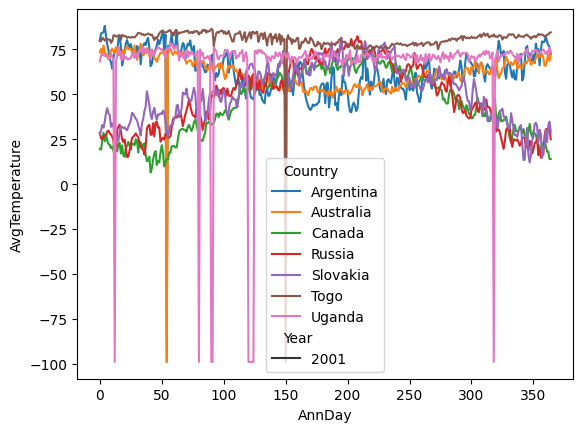

In [58]:
ax = sns.lineplot(data=df, x="AnnDay", y="AvgTemperature", hue="Country", style="Year")





#### Clean data 
I will just remove the `-99` values and interpolate the time series. To do this, I will go back to the `rawdf` since data were already averaged. 

/tmp/ipykernel_1139016/1633926191.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


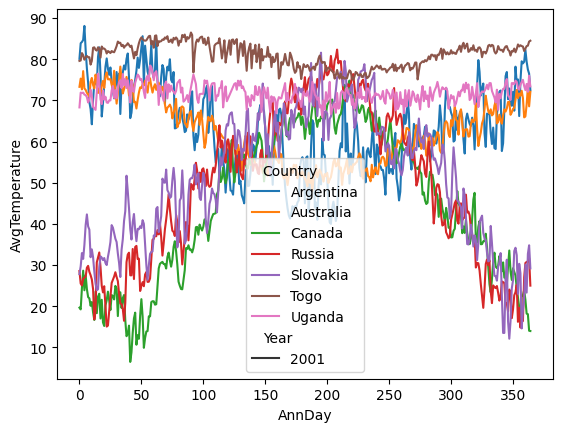

In [59]:
# Interpolate missing data
rawdf["AvgTemperature"] = (rawdf["AvgTemperature"]
                           .replace(-99, np.nan)
                           .interpolate())

# Average across cities
df = (rawdf.groupby(by=["Country", "Year", "Month", "Day"])
        .mean()
        .reset_index())

# Create new var for day within each year
df["AnnDay"] = df.groupby(["Country", "Year"]).cumcount()
df = df.drop(columns=["Month", "Day"])

# Plot again
ax = sns.lineplot(data=df, x="AnnDay", y="AvgTemperature", hue="Country", style="Year")



In [60]:
# Rearrange data so that each column is Country-Year combination
df = df.pivot(index="AnnDay", values="AvgTemperature", columns=["Country", "Year"])
df.columns = [x+str(y) for  (x, y) in df.columns.values]

### Calculating correlation coefficients
I will be using two methods:
1) Pearson correlation - correlates every pair of variables
2) Partial Pearson correlation - takes the coveriance of other variables into account

#### Plot correlations using standard heatmap plot

> *Partial correlation is included in `pandas` as the `pcorr()` method if you have the `pingouin` package installed only. For now it can only perform Pearson correlation, although [an issue has been reaise to include Spearman](https://github.com/raphaelvallat/pingouin/issues/337)* 



Text(0.5, 1.0, 'Partial correlation')

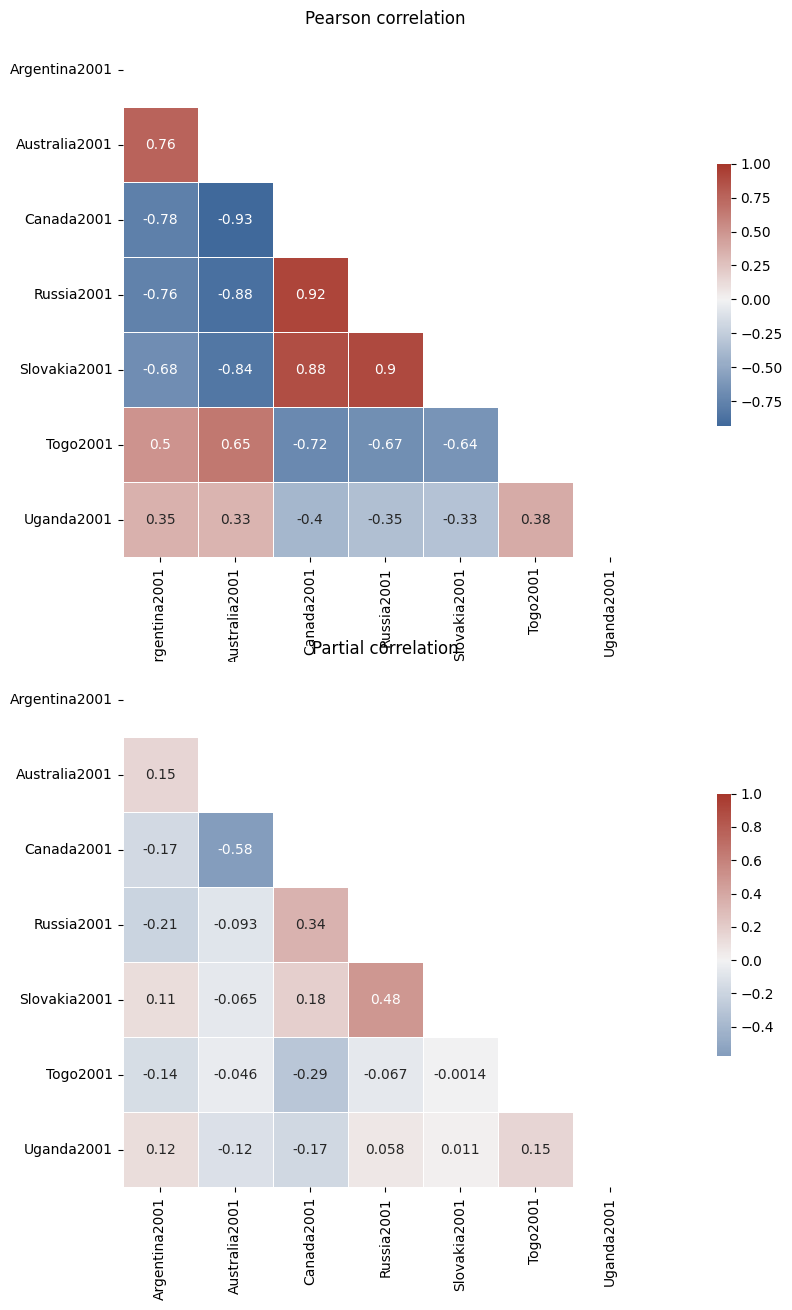

In [66]:
## Standard correlation
cdf = df.corr(method="pearson")

## Partial correlation
pdf = df.pcorr()

## plot
f, ax = plt.subplots(2,1,figsize=(18, 15))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cdf, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", 
                            as_cmap=True)
ax[0]= sns.heatmap(cdf, mask=mask, cmap=cmap, vmax=1, center=0, ax=ax[0],
            square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})
ax[0].set_title("Pearson correlation")

ax[1]= sns.heatmap(pdf, mask=mask, cmap=cmap, vmax=1, center=0, ax=ax[1],
            square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})
ax[1].set_title("Partial correlation")




### Plot the data as a graph
Here are some of the features that would be nice: 
 - the **color** and **width** of the edges should refelct the strength of the correlation between the connecting nodes
 - the correlations for the full correlation are quite high, so I will only show higher than 0.8 or lower than -0.8

#### Full correlation graph 
The `networkx` package has a lot of different layout options, see [here](https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout), here I am just using circular layout. 

**Graph properties**  
`node_shape` is defined by `matplotlib` markers, see [here](https://matplotlib.org/stable/api/markers_api.html)
`edge_color` can be either a single color for all or specific color for each edge, here I used a colormap from matplotlib
`pos` is the layout of the graph 


The plot seems to make sense, the notrther countries tend to correlate highly in their 2001 temperature. 


{('Argentina2001',
  'Australia2001'): Text(0.8117449049695933, 0.39091574665765266, '0.762'),
 ('Argentina2001',
  'Canada2001'): Text(0.38873954709122704, 0.48746394302286616, '-0.776'),
 ('Argentina2001',
  'Russia2001'): Text(0.04951560754382245, 0.21694190912785158, '-0.763'),
 ('Argentina2001',
  'Slovakia2001'): Text(0.04951560754382245, -0.21694186229563228, '-0.68'),
 ('Argentina2001',
  'Togo2001'): Text(0.38873951728890566, -0.4874639259929682, '0.502'),
 ('Argentina2001',
  'Uganda2001'): Text(0.8117448155626292, -0.3909157892323974, '0.351'),
 ('Australia2001',
  'Canada2001'): Text(0.2004844520608203, 0.8783796811655699, '-0.931'),
 ('Australia2001',
  'Russia2001'): Text(-0.13873948748658427, 0.6078576472705552, '-0.884'),
 ('Australia2001',
  'Slovakia2001'): Text(-0.13873948748658427, 0.1739738758470714, '-0.837'),
 ('Australia2001',
  'Togo2001'): Text(0.20048442225849894, -0.09654818785026448, '0.648'),
 ('Australia2001',
  'Uganda2001'): Text(0.6234897205322225, -5.

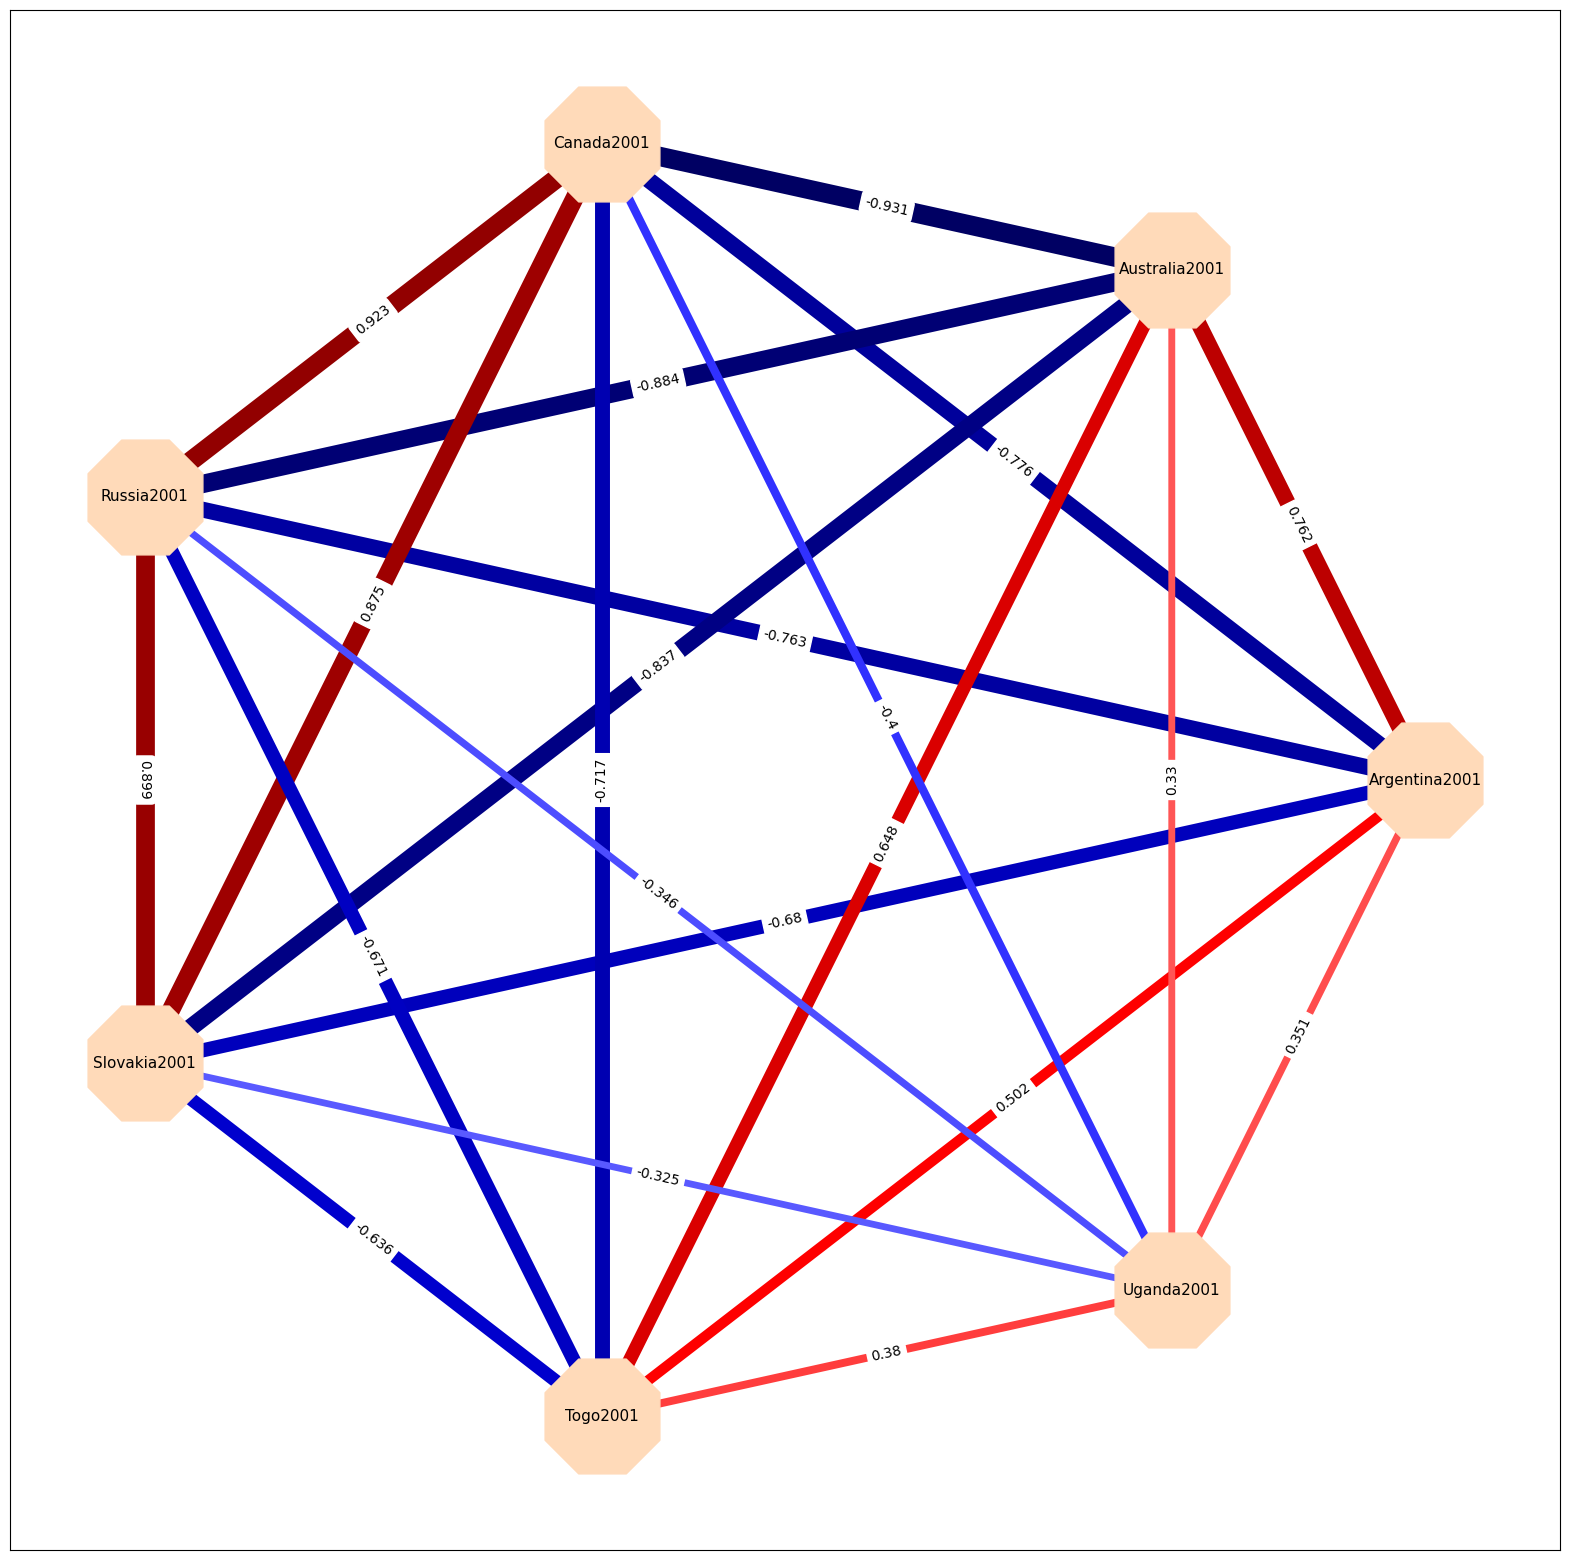

In [62]:
# stack data
links = cdf.stack().reset_index()
links.columns = ['var1', 'var2', 'value']



# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (abs(links['value']) > 0.2) & (links['var1'] != links['var2']) ]

# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# create edge labels (i.e. correlation coefs)
edge_labels = dict([((n1, n2), round(float(links_filtered.query('var1==@n1 & var2==@n2')["value"]),3))
                for n1, n2 in G.edges])
                
# create edge widths (proportional to correlation coefs)
edge_widths= np.array([ round(float(links_filtered.query('var1==@n1 & var2==@n2')["value"]),3) for n1, n2 in G.edges])

# Prepare edge color
# choose color paltte here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.seismic)



# Plot the network:
f, ax = plt.subplots(1,1,figsize=(20, 20))
nx.draw_networkx(G, with_labels=True, 
        node_color="peachpuff", 
        node_size=8000, 
        edge_color=mapper.to_rgba(edge_widths),
        style="solid",
        width=edge_widths*15,
        node_shape="8", 
        font_size=11, 
        pos=nx.circular_layout(G), 
        #pos=nx.kamada_kawai_layout(G), 
        ax=ax)


nx.draw_networkx_edge_labels(G, pos=nx.circular_layout(G), edge_labels=edge_labels, ax=ax)


#### Partial correlation graph

{('Argentina2001',
  'Australia2001'): Text(0.8117449049695933, 0.39091574665765266, '0.152'),
 ('Argentina2001',
  'Canada2001'): Text(0.38873954709122704, 0.48746394302286616, '-0.167'),
 ('Argentina2001',
  'Russia2001'): Text(0.04951560754382245, 0.21694190912785158, '-0.21'),
 ('Argentina2001',
  'Slovakia2001'): Text(0.04951560754382245, -0.21694186229563228, '0.113'),
 ('Argentina2001',
  'Togo2001'): Text(0.38873951728890566, -0.4874639259929682, '-0.139'),
 ('Argentina2001',
  'Uganda2001'): Text(0.8117448155626292, -0.3909157892323974, '0.119'),
 ('Australia2001',
  'Canada2001'): Text(0.2004844520608203, 0.8783796811655699, '-0.575'),
 ('Australia2001',
  'Russia2001'): Text(-0.13873948748658427, 0.6078576472705552, '-0.093'),
 ('Australia2001',
  'Slovakia2001'): Text(-0.13873948748658427, 0.1739738758470714, '-0.065'),
 ('Australia2001',
  'Uganda2001'): Text(0.6234897205322225, -5.1089693697825567e-08, '-0.123'),
 ('Canada2001',
  'Russia2001'): Text(-0.5617448453649505, 

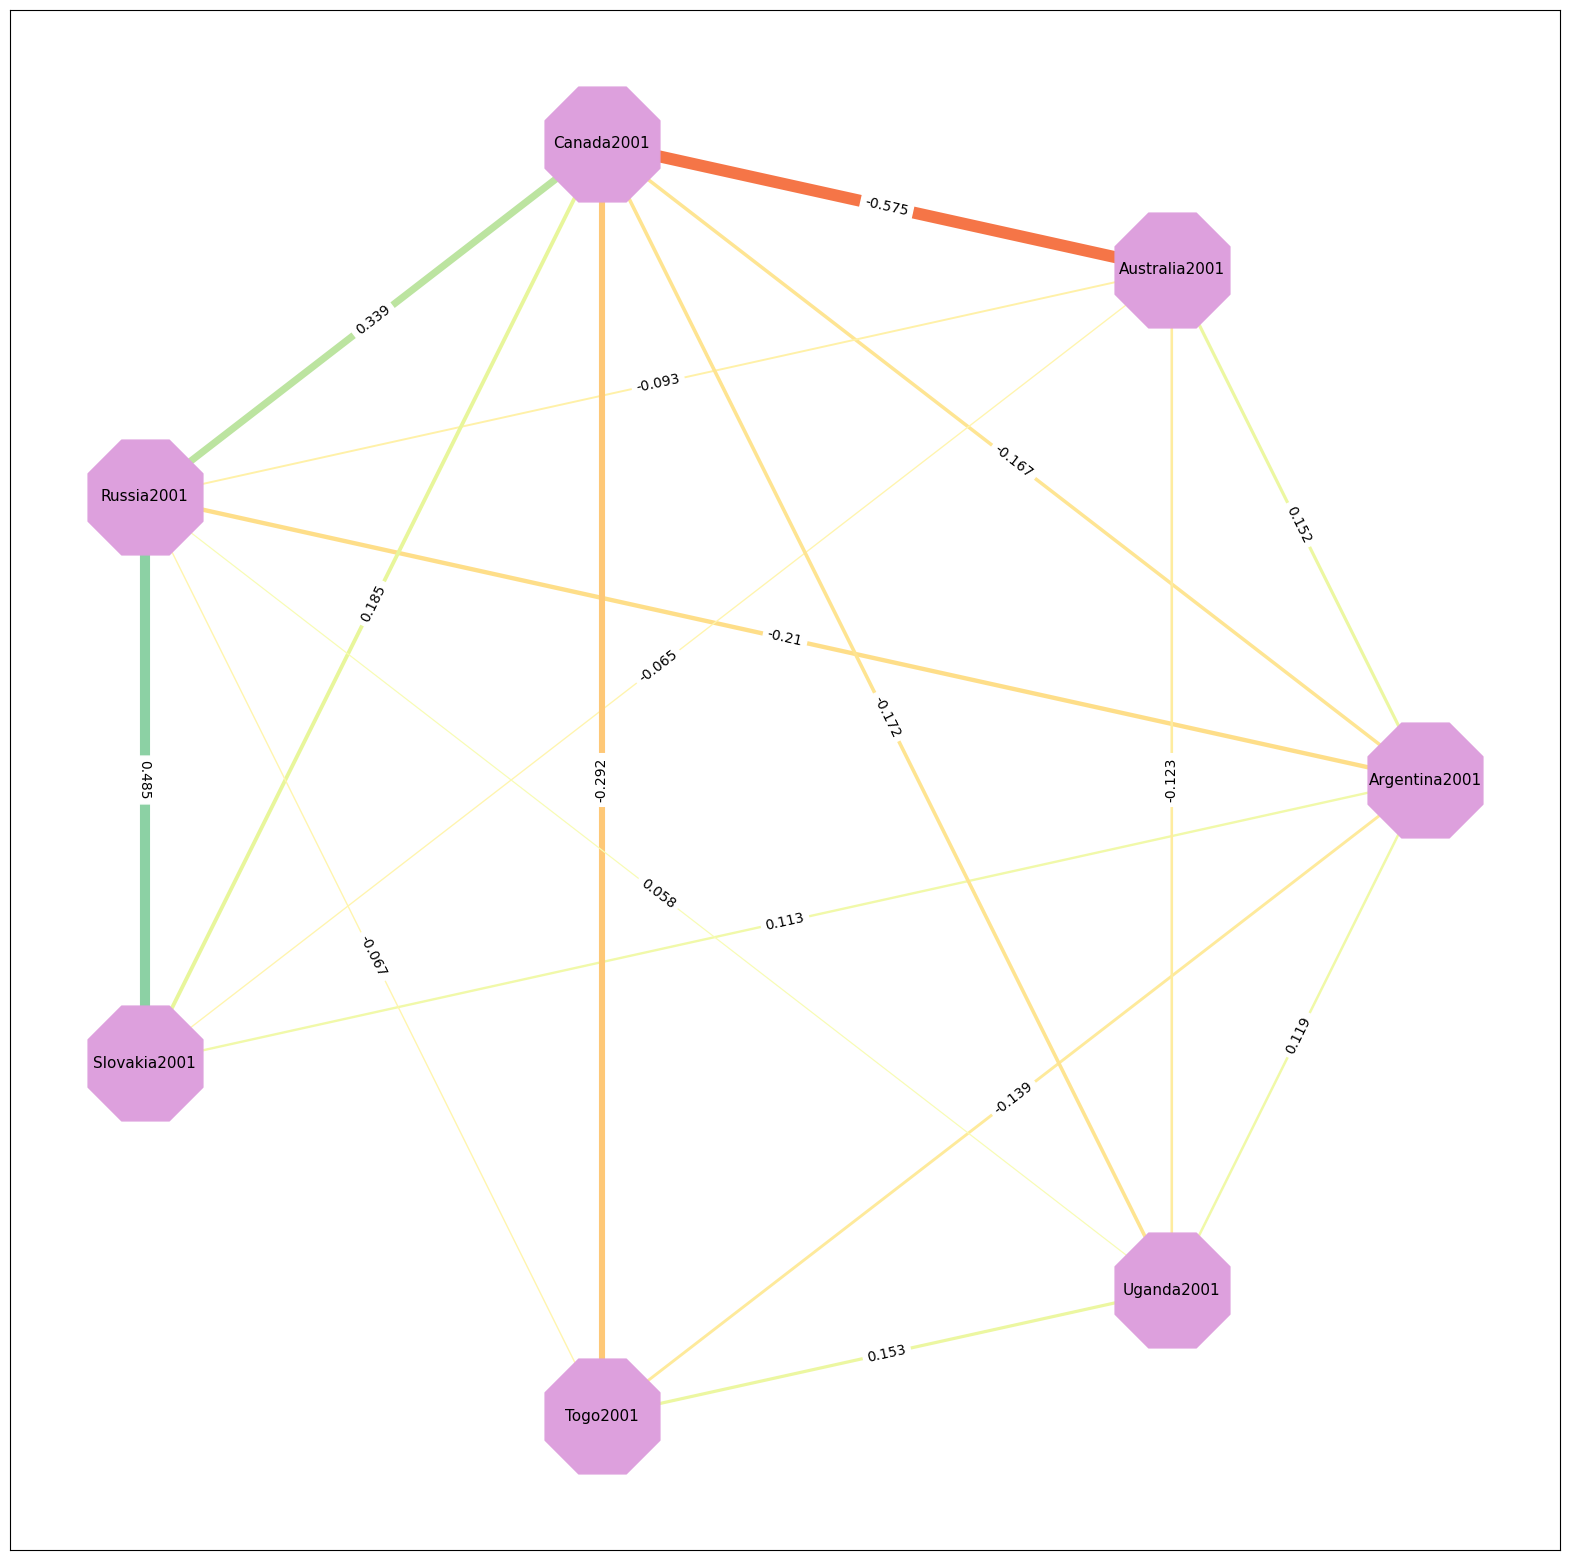

In [65]:
# stack data
links = pdf.stack().reset_index()
links.columns = ['var1', 'var2', 'value']



# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (abs(links['value']) > 0.05) & (links['var1'] != links['var2']) ]

# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# create edge labels (i.e. correlation coefs)
edge_labels = dict([((n1, n2), round(float(links_filtered.query('var1==@n1 & var2==@n2')["value"]),3))
                for n1, n2 in G.edges])
                
# create edge widths (proportional to correlation coefs)
edge_widths= np.array([ round(float(links_filtered.query('var1==@n1 & var2==@n2')["value"]),3) for n1, n2 in G.edges])

# Prepare edge color
# choose color paltte here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)

# Prepare node colors 
nodcol = []
for node in G:
    if ("TF" in node) or ("STAI" in node):
        nodcol.append('plum')
    else: 
        nodcol.append('peachpuff')


# Plot the network:
f, ax = plt.subplots(1,1,figsize=(20, 20))
nx.draw_networkx(G, with_labels=True, 
        node_color="plum", 
        node_size=8000, 
        edge_color=mapper.to_rgba(edge_widths),
        #edge_labels=edge_labels,
        style="solid",
        width=edge_widths*15,
        #linewidths=40,#links_filtered["value"]*20, 
        node_shape="8", 
        font_size=11, 
        pos=nx.circular_layout(G), 
        #pos=nx.kamada_kawai_layout(G), 
        ax=ax)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad="3%")

nx.draw_networkx_edge_labels(G, pos=nx.circular_layout(G), edge_labels=edge_labels, ax=ax)